## Credit Card Fraud Detection


### Task

Using this credit card fraud dataset develop an algorithm to predict fraud. Prioritize correctly finding fraud rather than correctly labeling non-fraudulent transactions.

### Dataset

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. 

Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. 

Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.


### Notes on precision: 

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). 

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
df=pd.read_csv("../creditcard.csv")

In [4]:
df.head(n=5)
# time doesn't present a lot of value (separately for future evaluation) 
# since the start date or specific time is not important for our purpose

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
X = df.drop(['Class', 'Time'], 1)
Y = df['Class']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [7]:
rfc = RandomForestClassifier().fit(X_train, y_train)

In [8]:
print('Accuracy with 20% Holdout: ' + str(rfc.score(X_test, y_test)))
print('Cross validation: ' + str(cross_val_score(RandomForestClassifier(), X, Y, cv=5)))

Accuracy with 20% Holdout: 0.999455777536
Cross validation: [ 0.99903444  0.99963133  0.99913976  0.99952599  0.99945577]


In [9]:
y_pred = rfc.predict(X_test)
print (classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56861
          1       0.93      0.75      0.83       101

avg / total       1.00      1.00      1.00     56962



The classification report shows us exactly what we suspected: 

Class imbalance is huge (on average, 56864 of non-fraudulent transactions vs 98 of fraudulent transactions), which brings us to the next problem: even if the precision and overall model accuracy appear to be excellent, the recall for fraud (how well we're catching every fraud transaction) is only 0.77

We can try to fight the class imbalance with the number of ways:
1. Under-sampling dominating class (synthetic sampling techniques)
2. Logistic regression or support vector machines ("SVM"), which should give a more accurate probability of a certain class. 
3. Create a custom cost function weighting higher when fraudulent transaction is undentified incorrectly

Let's try them starting from exploring other classification models and balances cost functions and see if we can improve the score without undersampling. We'll do under-sampling at the end and compare the results.

### Success criteria: 
To choose the best model: the precision for detecting fraud should be at least 0.95 and then we'll rank the models based on the recall rate. 

### Is there a clear differentiator among features?
Before we build any model, let's see how features relate to fraudulent cases and if we can identify a 'super feature', which can tell us right away the outcome.

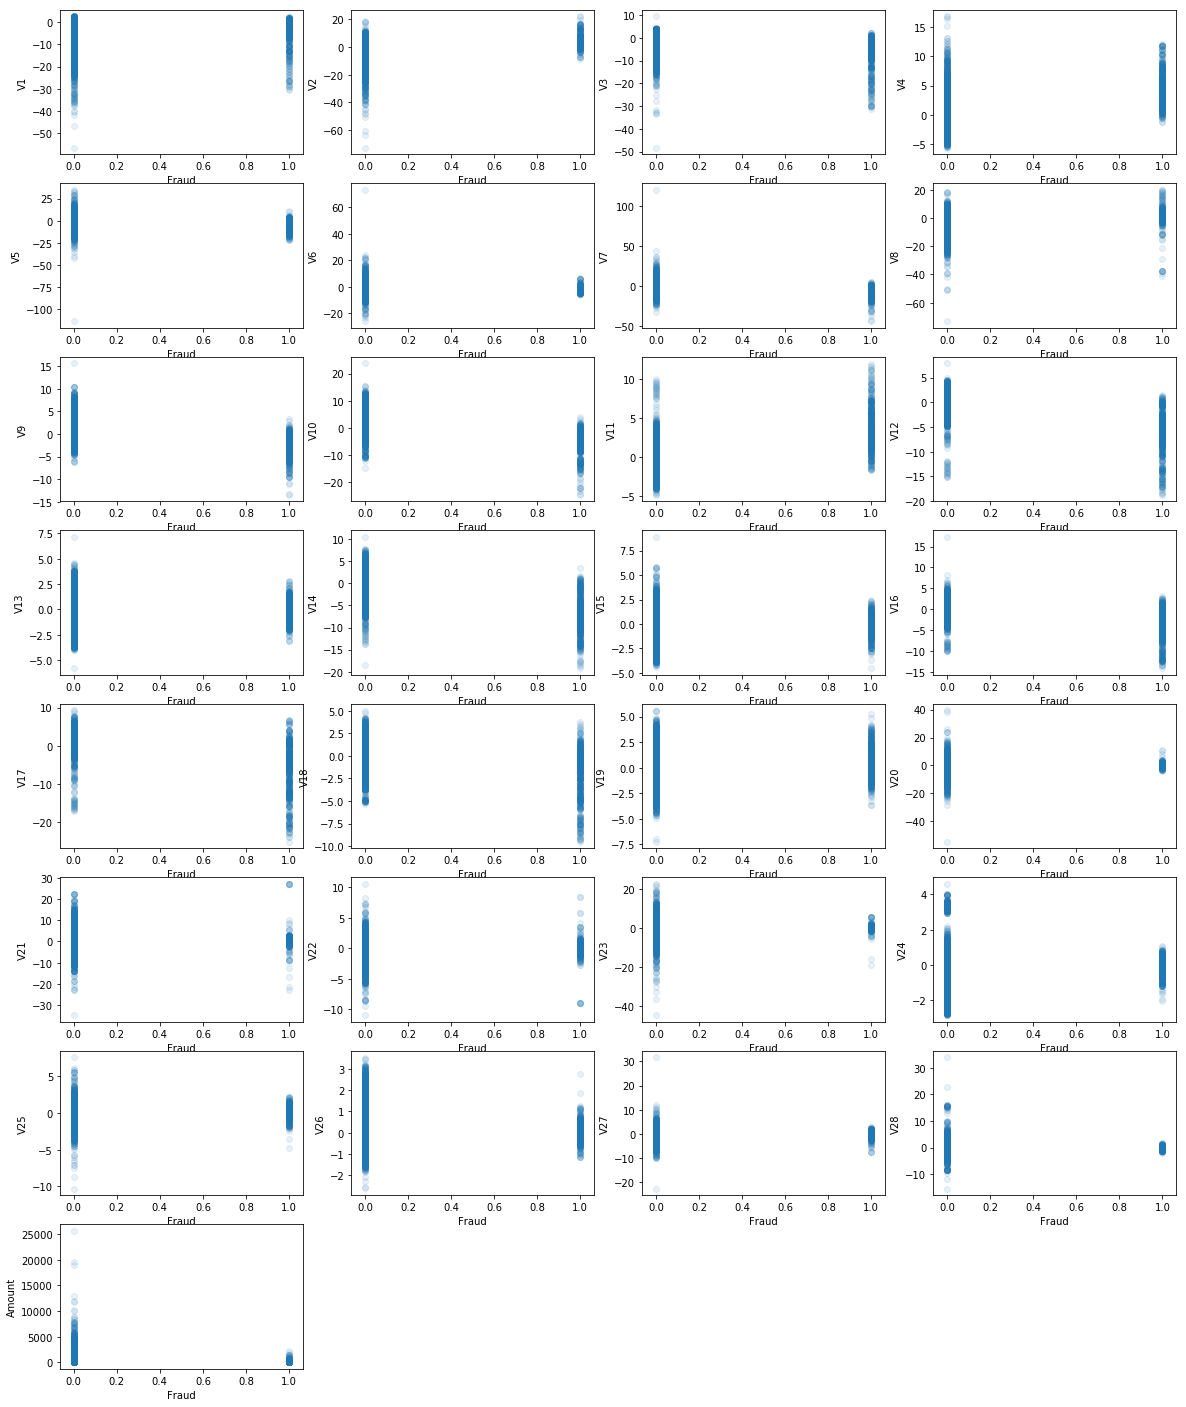

In [21]:
plt.figure(figsize=(20,25))
n=0
for column in X.columns:
    n+=1
    plt.subplot(8, 4, n) 
    plt.scatter(y=X[column], x=Y, alpha=.1)
    plt.xlabel('Fraud')
    plt.ylabel(column)

plt.show()

No simple clear 'cut' between fraud and non-fraud is visible. Mostly fraud is somewhere in between of the value range of different features. Only for a few features, fraud is somewhere higher, somewhere lower than the visual medium. 

### Models

#### 1.1. Logistic regression with Lasso regularization

In [9]:
print('Cross validation: ' + str(cross_val_score(linear_model.LogisticRegression(penalty='l1', C=.4), X, Y, cv=5)))

Cross validation: [ 0.999052    0.99931533  0.99894665  0.99929777  0.99905198]


In [10]:
lr = linear_model.LogisticRegression(penalty='l1', C=.4).fit(X_train, y_train)

In [11]:
y_pred = lr.predict(X_test)

In [12]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56876
          1       0.88      0.58      0.70        86

avg / total       1.00      1.00      1.00     56962



#### 1.2. Support vector machines classifier

Together with the fact the SVC model was training for ~30 min, the accuracy is lower than with the previous models. Let's see if by any chance the recall is higher. 

Nope.
Therefore, the best model so far was the RandomForestClassifier. 

#### 2. Changing cost function to 'balanced' to account for the class imbalance. 

In [13]:
# Random Forest
print('Cross validation: ' + str(cross_val_score(RandomForestClassifier(class_weight='balanced'), X, Y, cv=5)))

Cross validation: [ 0.99898178  0.99959622  0.99898176  0.99947332  0.99926265]


In [14]:
rfc = RandomForestClassifier(class_weight='balanced').fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [15]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56876
          1       0.95      0.69      0.80        86

avg / total       1.00      1.00      1.00     56962



Balanced class_weight doesn't really give us better recall rate. 

In [16]:
# Logistic Regression
print('Cross validation: ' + str(cross_val_score(linear_model.LogisticRegression(penalty='l1', C=.4, class_weight='balanced'),
                                                 X, Y, cv=5)))

Cross validation: [ 0.97642288  0.98595555  0.96469514  0.96315023  0.97793227]


In [17]:
lr = linear_model.LogisticRegression(penalty='l1', C=.4, class_weight='balanced').fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [18]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       1.00      0.98      0.99     56876
          1       0.06      0.91      0.12        86

avg / total       1.00      0.98      0.99     56962



We can see better performance of Logistic Regression with balanced class_weight than without for identifying maximum of fraudulent transactions, but precision of 0.06 signals us that the model labeling fraudulent transactions way too often.

Recall didn't improve while we've seen the worse precision score. Let's see if the under-sampling helps.

#### 3. Under-sampling of the dominating class 

In [19]:
from imblearn.under_sampling import RandomUnderSampler 
X_sample, Y_sample = RandomUnderSampler(random_state=1).fit_sample(X, Y)
print(('Balanced sample size: ' + str(Y_sample.shape)))

Balanced sample size: (984,)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_sample, Y_sample, test_size=0.2, random_state = 2)

Cross validation: [ 0.97979798  0.91414141  0.92346939  0.96428571  0.93367347]
             precision    recall  f1-score   support

          0       0.90      0.98      0.94        95
          1       0.98      0.90      0.94       102

avg / total       0.94      0.94      0.94       197



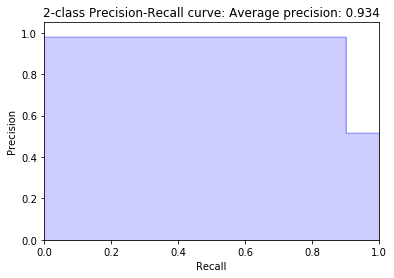

In [21]:
### Using Area Under Precision Recall curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

print('Cross validation: ' + str(cross_val_score(RandomForestClassifier(), X_sample, Y_sample, cv=5)))

rfc = RandomForestClassifier().fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print (classification_report(y_test, y_pred))

average_precision = average_precision_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: Average precision: {0:0.3f}'.format(
    average_precision));

Recall rate of 0.90 looks much better! Let's try it on previously mentioned models and see if we can catch fraud even better: 

Cross validation: [ 0.85353535  0.87878788  0.89795918  0.92857143  0.89795918]
             precision    recall  f1-score   support

          0       0.90      0.87      0.89        95
          1       0.89      0.91      0.90       102

avg / total       0.89      0.89      0.89       197



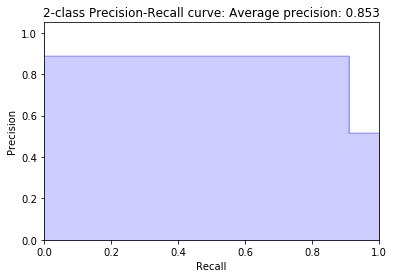

In [23]:
from sklearn.svm import SVC

print('Cross validation: ' + str(cross_val_score(SVC(), X_sample, Y_sample, cv=5)))

svc = SVC().fit(X_train, y_train)
y_pred = svc.predict(X_test)
print (classification_report(y_test, y_pred))

average_precision = average_precision_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: Average precision: {0:0.3f}'.format(
    average_precision));

Recall is better, but the precision fell more, so we see a lower Average precision score for SVM model.

Cross validation: [ 0.93939394  0.93434343  0.92346939  0.94897959  0.93367347]
             precision    recall  f1-score   support

          0       0.92      0.96      0.94        95
          1       0.96      0.92      0.94       102

avg / total       0.94      0.94      0.94       197



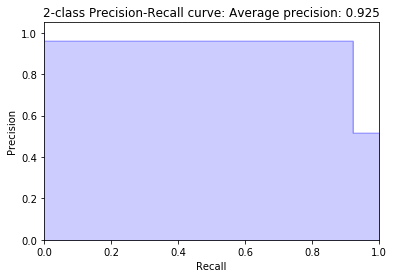

In [24]:
print('Cross validation: ' + str(cross_val_score(linear_model.LogisticRegression(penalty='l1', C=.4), 
                                                 X_sample, Y_sample, cv=5)))

lr = linear_model.LogisticRegression(penalty='l1', C=.4).fit(X_train, y_train)
y_pred = lr.predict(X_test)
print (classification_report(y_test, y_pred))

average_precision = average_precision_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: Average precision: {0:0.3f}'.format(
    average_precision));

Hmm, Logistic Regression is actually very close to outperforming the other models now! 

It's the n-th time I'm running the re-sampling and for a few runs the logistic regression has indeed shown slightly higher result for both average precision and recall. What was noticed is that the results for Logistic Regression were more stable (the average percision didn't fluctuate between runs). 

#### Conclusion: 
We can treat Random Forest Classifier and Logistic Regression as equally good models with undersampling of dominating class. 

Based on our otimizing metric, the best model is the Linear Regression as it gives us a higher recall rate. Also, we need to keep in mind the higher accuracy and lower stability for Random Forest Classifier and vice versa for Logistic Regression.

### Test our best model on the initial data without replacement used for training

In [ ]:
y_pred_untouched = rfc.predict(X_untouched)
print (classification_report(Y_untouched, y_pred_untouched))

average_precision = average_precision_score(Y_untouched, y_pred_untouched)
precision, recall, _ = precision_recall_curve(Y_untouched, y_pred_untouched)

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: Average precision: {0:0.3f}'.format(
    average_precision));